# SMI experiments

- [ ] From ACL papers, CNN News, Legal Cases,
- [ ] Use GMM to find the distribution of key words (or other model with explicit structure (i.e. Introduction and Conclusion in ACL papers)) 
- [ ] See the truncated position of Introduction and Conclusion in scientific paper corpus

In [1]:
import sys
sys.path.append("/home/ubuntu/SLN-Summarization/src/sln_summ")

In [2]:
%load_ext autoreload
%autoreload 2

import corpus
import tokenizer

paper_items = corpus.read_paper_corpus(200)
cnn_items = corpus.read_cnn_corpus(200)
legal_items = corpus.read_legal_corpus(200, truth_selection="summ")

legal-corpus: 100%|██████████| 200/200 [00:01<00:00, 167.37it/s]


In [5]:
import math
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

def mean(lst):
    return sum(lst) / len(lst)

def get_key_distribution(sentences, key_words, scatter=True, prop=True):
    key_words = set(key_words)
    distributions  = [[] for _ in range(100)]

    last_pos = 0
    for i, words in enumerate(sentences, 1):
        pos =  math.ceil(i * 100 / len(sentences))
        if prop:
            dist = len(set(words) & key_words) / len(words)
        else:
            dist = len(set(words) & key_words)

        if len(sentences) < 100:
            for p in range(last_pos, pos):
                distributions[p].append(dist)
            last_pos = pos
        else:
            distributions[pos - 1].append(dist)
    return distributions

def get_items_distribution(items, abstract_remove_stop=True, text_remove_stop=True, proportion=False):
    all_distributions = [[] for _ in range(100)]
    for item in items:
        abstract, text, informative, detailed = item
        key_words = list(itertools.chain(*tokenizer.tokenize_sentences_and_words(abstract.lower(), remove_stop=abstract_remove_stop)))

        sentences = tokenizer.tokenize_sentences_and_words(text.lower(), remove_stop=text_remove_stop)

        distribution = get_key_distribution(sentences, key_words, prop=proportion)
        distribution = [mean(dist) for dist in distribution]

        for i, value in enumerate(distribution):
            all_distributions[i].append(value)
    
    all_distributions = [mean(dist) for dist in all_distributions]

    return all_distributions

def plot_items_distribution(items, title, corpus=None, *args, **kwargs):
    distribution = get_items_distribution(items, *args, **kwargs)

    fig = plt.figure(figsize=(10, 5))
    axis = fig.add_subplot(1, 1, 1)
    axis.set_title(title)
    
    axis.set_ylabel("count of overlap key words")
    axis.set_xlabel("position percentage (%)")

    plt.xlim(-1, 100)

    # for pos, color in zip(pos_names, ["green", "brown", "blue"]):
    # sns.distplot(props, label="test", rug=False, hist=False, color="green", ax=axis)
    if corpus == "paper":
        colors = ['tomato']*15 + ['cornflowerblue']*81 + ['darkorange']*4
        import matplotlib.patches as mpatches

        red_patch = mpatches.Patch(color='tomato', label='Introduction')
        blue_path = mpatches.Patch(color='cornflowerblue', label='text')
        yellow_patch = mpatches.Patch(color='darkorange', label='Conclusion')
        plt.legend(handles=[red_patch, blue_path, yellow_patch])
    elif corpus == "cnn":
        colors = ['cornflowerblue']*100
    
        plt.plot([0, 100], [3, 3], c='b', linestyle='--')
        plt.plot([0, 100], [2, 2], c='b', linestyle='--')
        plt.text(80, 3, '3', ha='center', va='bottom', fontsize=10.5)
        plt.text(80, 2, '2', ha='center', va='bottom', fontsize=10.5)
    elif corpus == "legal":
        colors = ['cornflowerblue']*100
        plt.plot([0, 100], [1.5, 1.5], c='b', linestyle='--')
        plt.text(80, 1.5, '1.5', ha='center', va='bottom', fontsize=10.5)

    plt.bar(range(100), distribution, color=colors)
    # axis.legend(fontsize="xx-large")
    plt.savefig(f"{title}.png", dpi=300)
    plt.savefig(f"{title}.svg")

    plt.show()

def plot_items_distribution_all(items):


    fig = plt.figure(figsize=(30, 15))

    for i, *args in enumerate(itertools.product((True, False), (True, False), (True, False)), 1):
        args = args[0]
        (abstract_remove_stop, text_remove_stop, proportion) = args
        axis = plt.subplot(2, 4, i)
        axis.set_title(f"ab_rs{abstract_remove_stop},txt_rs{text_remove_stop},prop{proportion}")

        distribution = get_items_distribution(items, *args)
        plt.bar(range(100), distribution)
        # axis.legend(fontsize="xx-large")

    plt.show()

In [6]:
intro_pro = conclu_pro = 0
for item in paper_items:
    abstract, text, informative, detailed = item

    informative_sents = tokenizer.tokenize_sentences_and_words(informative, remove_stop=False)
    text_sents = tokenizer.tokenize_sentences_and_words(text, remove_stop=False)

    for i, (inf, txt) in enumerate(zip(informative_sents, text_sents)):
        if inf != txt:
            break
    
    introduction_sents = informative_sents[:i]
    concl_sents = informative_sents[i+1:]

    intro_pro += len(introduction_sents) / len(text_sents)
    conclu_pro += len(concl_sents) / len(text_sents)


intro_pro / len(paper_items), conclu_pro / len(paper_items)

(0.141417922102162, 0.04024816730871268)

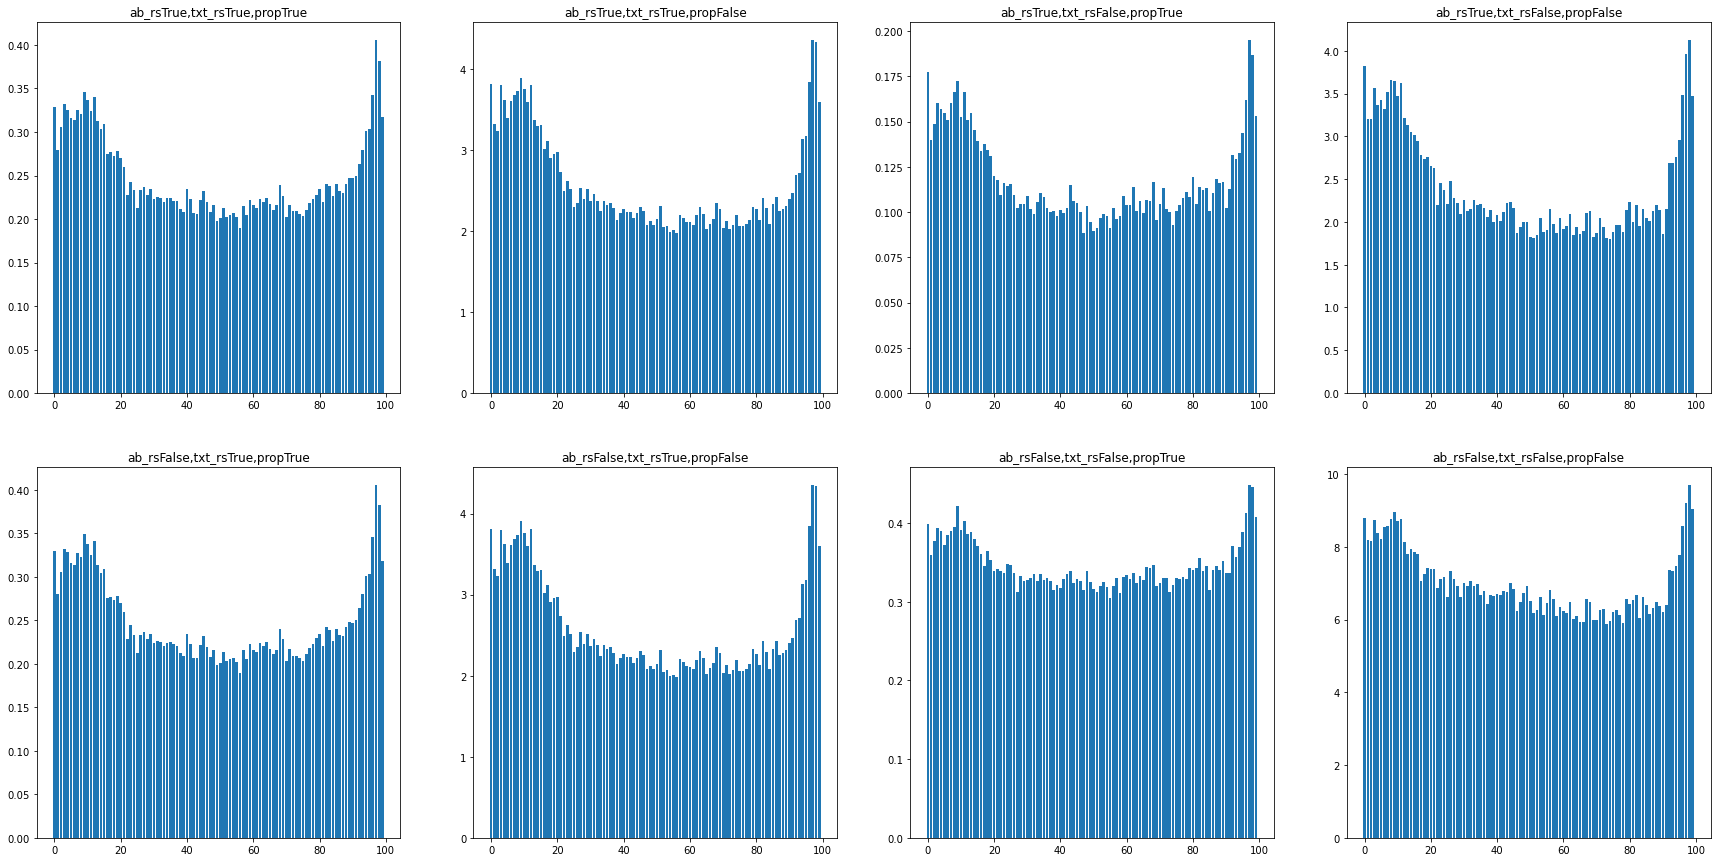

In [31]:
plot_items_distribution_all(paper_items)

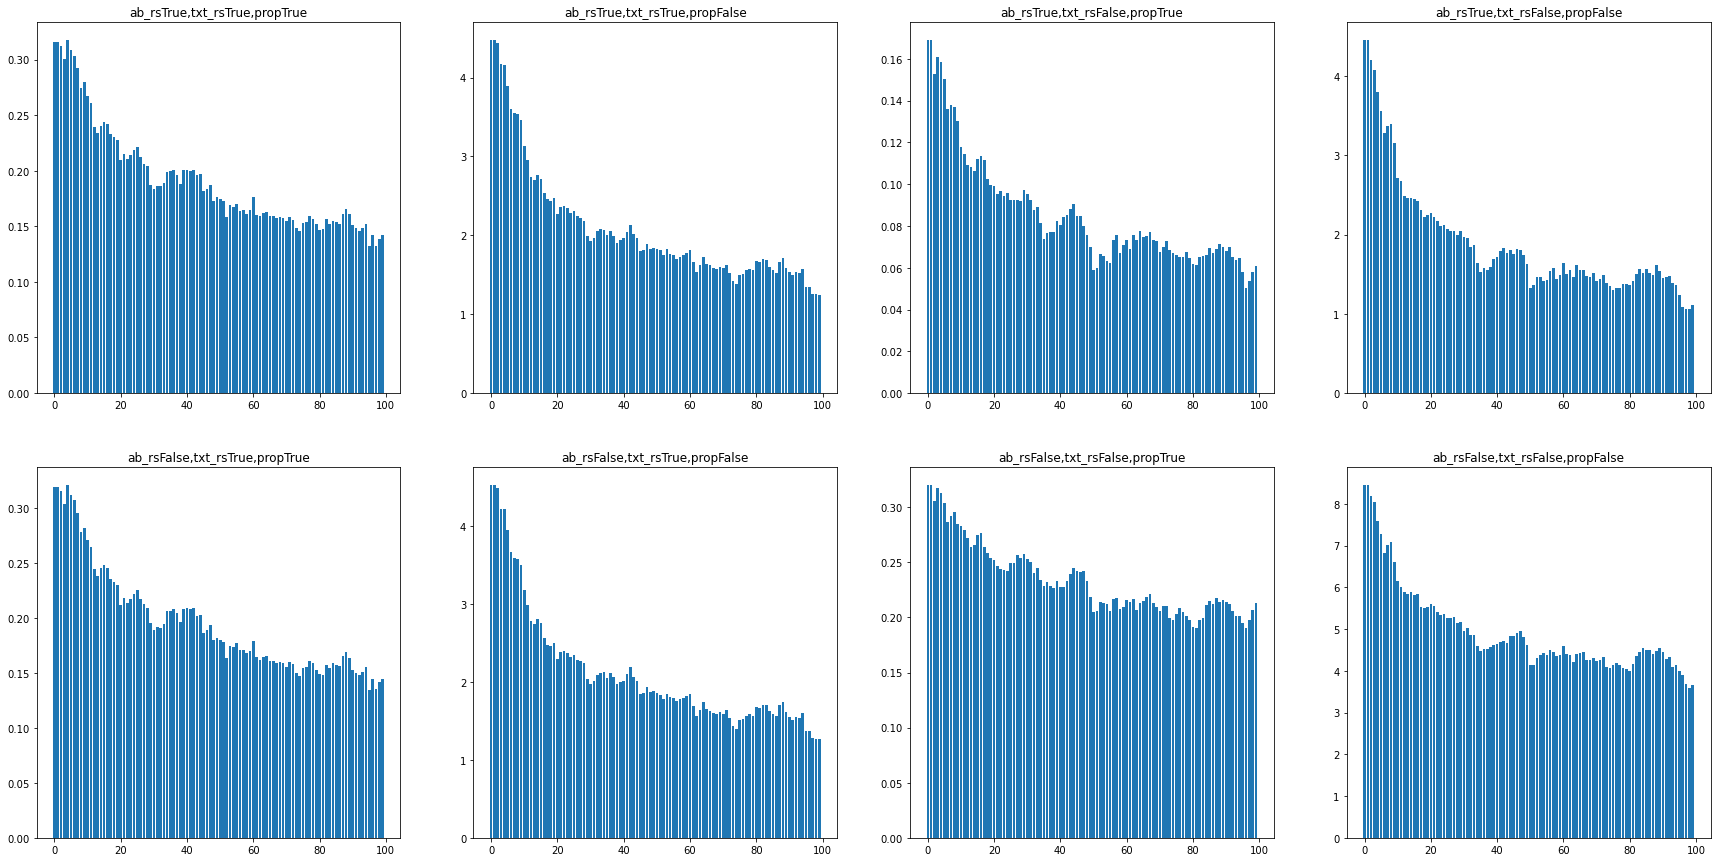

In [30]:
plot_items_distribution_all(cnn_items)

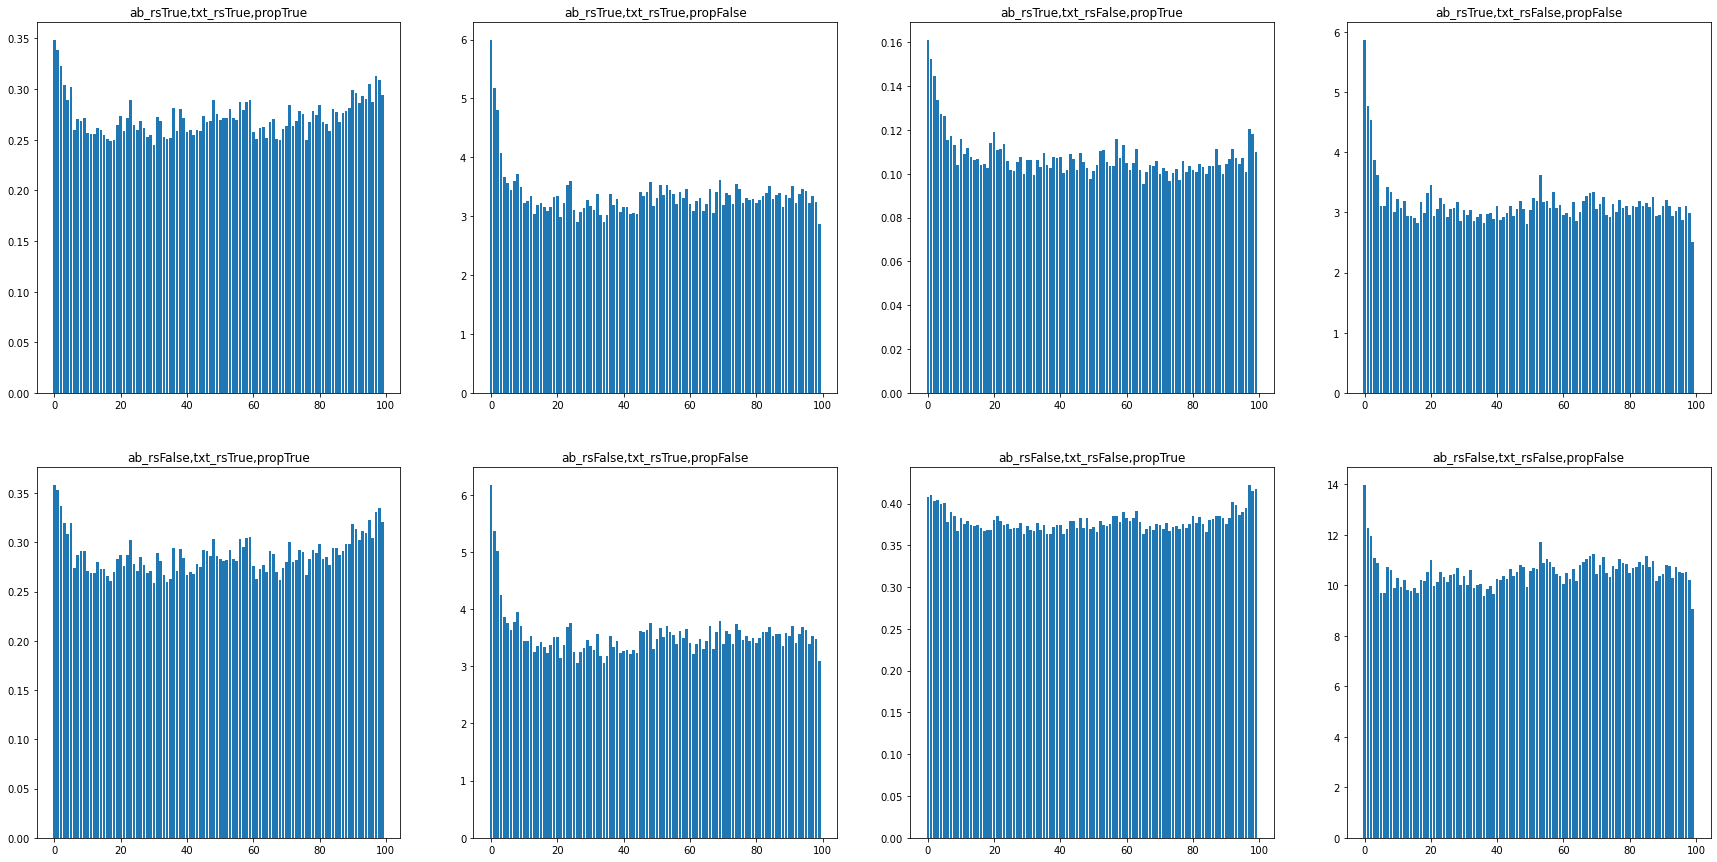

In [32]:
plot_items_distribution_all(legal_items)

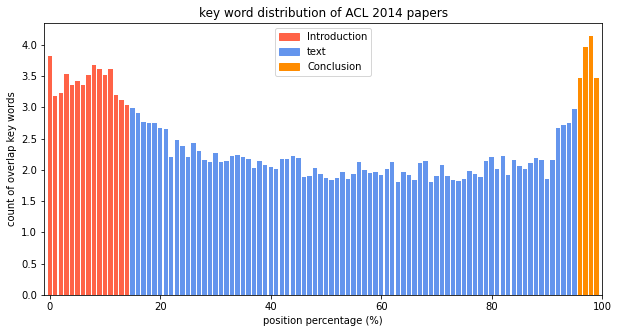

In [7]:
plot_items_distribution(paper_items, title="key word distribution of ACL 2014 papers", corpus="paper", abstract_remove_stop=True, text_remove_stop=False, proportion=False)

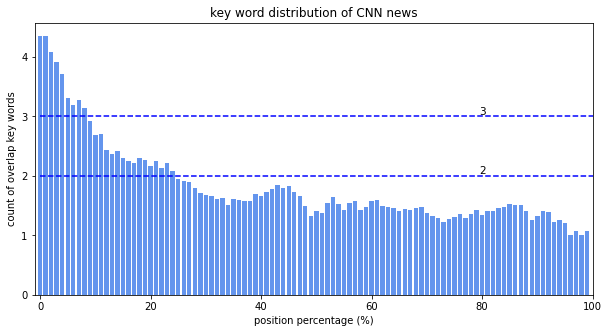

In [8]:
plot_items_distribution(cnn_items, title="key word distribution of CNN news", corpus="cnn", abstract_remove_stop=True, text_remove_stop=False, proportion=False)

legal-corpus: 100%|██████████| 500/500 [00:02<00:00, 181.77it/s]


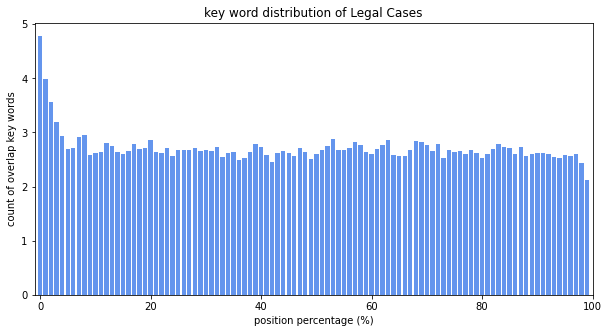

In [83]:
legal_items = corpus.read_legal_corpus(500, truth_selection="summ")
plot_items_distribution(legal_items, title="key word distribution of Legal Cases", corpus="legal", abstract_remove_stop=True, text_remove_stop=False, proportion=False)

legal-corpus: 100%|██████████| 500/500 [00:02<00:00, 225.03it/s]


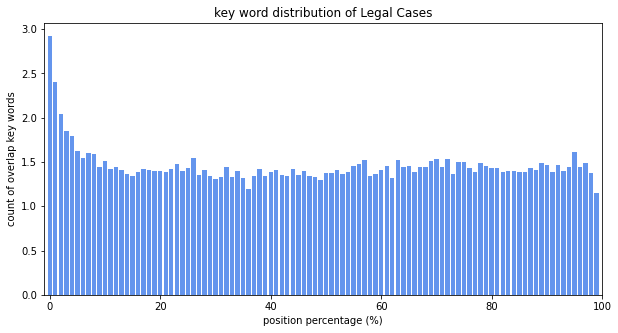

In [84]:
legal_items = corpus.read_legal_corpus(500, truth_selection="cite")
plot_items_distribution(legal_items, title="key word distribution of Legal Cases", corpus="legal", abstract_remove_stop=True, text_remove_stop=False, proportion=False)

legal-corpus: 100%|██████████| 100/100 [00:00<00:00, 302.06it/s]


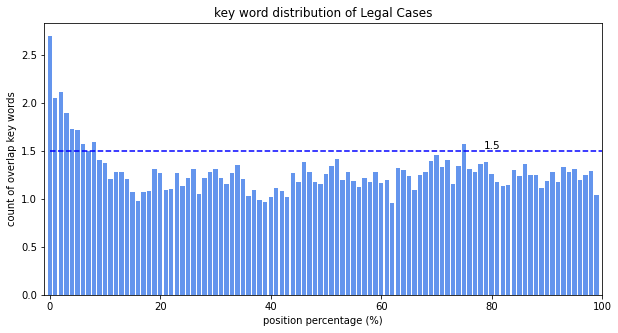

In [9]:
legal_items = corpus.read_legal_corpus(100, truth_selection="cite")
plot_items_distribution(legal_items, title="key word distribution of Legal Cases", corpus="legal", abstract_remove_stop=True, text_remove_stop=False, proportion=False)

legal-corpus: 100%|██████████| 200/200 [00:00<00:00, 281.01it/s]


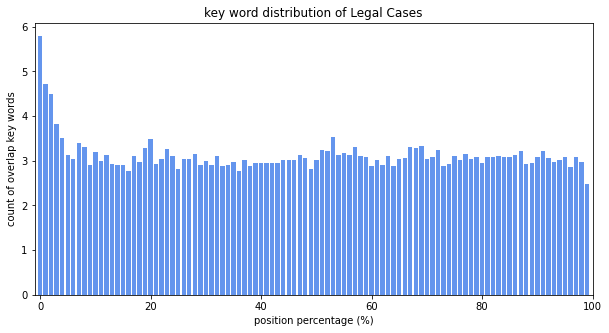

In [77]:
legal_items = corpus.read_legal_corpus(200, truth_selection="all")
plot_items_distribution(legal_items, title="key word distribution of Legal Cases", corpus="legal", abstract_remove_stop=True, text_remove_stop=False, proportion=False)

In [63]:
dist_prop(get_items_distribution(cnn_items))

0.1  is  5
0.1  is  6
0.1  is  7
0.1  is  8
0.1  is  9
0.1  is  10
0.2  is  11
0.2  is  12
0.2  is  13
0.2  is  14
0.2  is  15
0.2  is  16
0.2  is  17
0.2  is  18
0.3  is  19
0.3  is  20
0.3  is  21
0.3  is  22
0.3  is  23
0.3  is  24
0.3  is  25
0.3  is  26
0.3  is  27
0.4  is  28
0.4  is  29
0.4  is  30
0.4  is  31
0.4  is  32
0.4  is  33
0.4  is  34
0.4  is  35
0.4  is  36
0.4  is  37
0.5  is  38


In [62]:
dist_prop(get_items_distribution(legal_items))

0.1  is  8
0.1  is  9
0.1  is  10
0.1  is  11
0.1  is  12
0.1  is  13
0.1  is  14
0.1  is  15
0.1  is  16
0.1  is  17
0.2  is  18
0.2  is  19
0.2  is  20
0.2  is  21
0.2  is  22
0.2  is  23
0.2  is  24
0.2  is  25
0.2  is  26
0.2  is  27
0.2  is  28
0.3  is  29
0.3  is  30
0.3  is  31
0.3  is  32
0.3  is  33
0.3  is  34
0.3  is  35
0.3  is  36
0.3  is  37
0.3  is  38
0.3  is  39
0.4  is  40
0.4  is  41
0.4  is  42
0.4  is  43
0.4  is  44
0.4  is  45
0.4  is  46
0.4  is  47
0.4  is  48
0.4  is  49
0.5  is  50


In [61]:
def dist_prop(dists):
    sum_dist = sum(dists)
    acc = 0
    for i, dist in enumerate(dists, 1):
        acc += dist
        if acc / sum_dist >= 0.5:
            print(0.5, " is ", i)
            break
        elif acc / sum_dist >= 0.4:
            print(0.4, " is ", i)
        elif acc / sum_dist >= 0.3:
            print(0.3, " is ", i)
        elif acc / sum_dist >= 0.2:
            print(0.2, " is ", i)
        elif acc / sum_dist >= 0.1:
            print(0.1, " is ", i)

In [140]:
def get_key_distribution(sentences, key_words, scatter=True, prop=True):
    key_words = set(key_words)
    distributions  = [[] for _ in range(100)]

    last_pos = 0
    for i, words in enumerate(sentences, 1):
        pos =  math.ceil(i * 100 / len(sentences))
        if prop:
            dist = len(set(words) & key_words) / len(words)
        else:
            dist = len(set(words) & key_words)

        if len(sentences) < 100:
            for p in range(last_pos, pos):
                distributions[p].append(dist)
            last_pos = pos
        else:
            distributions[pos - 1].append(dist)
    return distributions

No handles with labels found to put in legend.


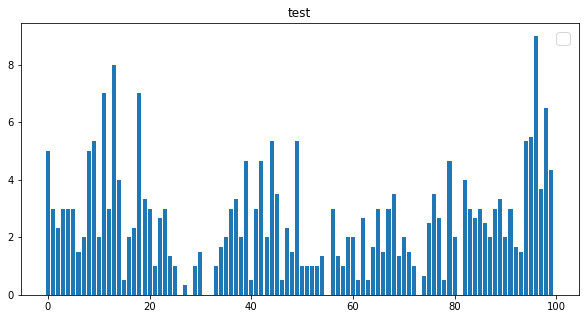

In [142]:
import math
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

def mean(lst):
    return sum(lst) / len(lst)

def get_items_proportion(items):
    all_distributions = [[] for _ in range(100)]
    for item in items:
        key_words = list(itertools.chain(*tokenizer.tokenize_sentences_and_words(abstract.lower(), remove_stop=True)))
        distribution = get_key_distribution(tokenizer.tokenize_sentences_and_words(text.lower(), remove_stop=False), key_words, prop=False)
        distribution = [mean(dist) for dist in distribution]

        for i, value in enumerate(distribution):
            all_distributions[i].append(value)
    
    all_distributions = [mean(dist) for dist in all_distributions]

    return all_distributions

distribution = get_items_proportion(items)

fig = plt.figure(figsize=(10, 5))
axis = fig.add_subplot(1, 1, 1)
axis.set_title("test")

# for pos, color in zip(pos_names, ["green", "brown", "blue"]):
# sns.distplot(props, label="test", rug=False, hist=False, color="green", ax=axis)
plt.bar(range(100), distribution)
axis.legend(fontsize="xx-large")

plt.show()